# Projet Otto Kaggle

In [241]:
# imports
import numpy as np
import pandas as pd

In [242]:
# Load files 
panda_dataset = pd.read_csv('train.csv')
panda_testset = pd.read_csv('test.csv')
dataset = panda_dataset.values
dataset = dataset[:,1:]
test = panda_testset.values
testX = test[:, 1:]

In [243]:
print(dataset.shape)
print(testX.shape)

(61878, 94)
(144368, 93)


In [244]:
import sklearn.preprocessing as prep

np.random.shuffle(dataset)
endTrain = round(0.9 * len(dataset))
train = dataset[:endTrain, :]
valid = dataset[endTrain:, :]

trainy = train[:, -1:].reshape(-1)
trainX = train[:, :-1]

validy = valid[:, -1:].reshape(-1)
validX = valid[:, :-1]

def preproc(data):
    d = prep.normalize(data, norm='l1', axis=0)
    d = prep.scale(d, axis=0)
    return d

trainX = preproc(trainX)
validX = preproc(validX)
testX = preproc(testX)


In [245]:
print(trainX.shape)
print(validX.shape)

(55690, 93)
(6188, 93)


In [246]:
#Evaluation function
#Refer to:https://www.kaggle.com/c/otto-group-product-classification-challenge/details/evaluation
def evaluation(label,pred_label):
    keep_numclass = np.vectorize(lambda w: int(w[-1]))
    labels = keep_numclass(label)
    num = len(labels)
    num_labels = len(pred_label[0])
    logloss = 0.0
#     print(labels)
#     print(pred_label)
    for i in range(num):
        p = max(min(pred_label[i][labels[i]-1],1-10**(-15)),10**(-15))
        logloss += np.log(p)
    logloss = -1*logloss/num
    return logloss

In [247]:
def saveResult(probas, filename = "submission.csv"):
#     col = np.concatenate((['id'], np.unique(panda_dataset['target'].values)))
    col = np.unique(panda_dataset['target'].values)
    indices = np.arange(len(probas)).reshape(-1,1)
#     submit = np.concatenate((indices, probas), axis=1)
    submission = pd.DataFrame(probas, columns=col)
    submission.index += 1
#     print(submission)
    submission.to_csv(filename, index=True, index_label='id')
    

# prediction = model.predict_proba(test)
# saveResult(prediction)

In [248]:
from sklearn.ensemble import RandomForestClassifier

def classif_randomForest(trainX, trainy, validX, validy, testX, name='randomForest_submission.csv'):
    model = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_features=5)
    model.fit(trainX, trainy)
    print("Model trained")
    
#     pred_valid_normal = model.predict(validX)
    pred_valid = model.predict_proba(validX)
    print("Evaluation (kaggle) of validation set :", evaluation(validy, pred_valid))
#     print(mtc.accuracy_score(validy, pred_valid_normal))
    
    testProbas = model.predict_proba(testX)
    saveResult(testProbas, name)


In [249]:
from sklearn.svm import SVC

def classif_SVM(trainX, trainy, validX, validy, testX, name='svm_submission.csv'):
    model = SVC(probability=True)
    model.fit(trainX, trainy)
    print("Model trained")
    
#     pred_valid_normal = model.predict(validX)
    pred_valid = model.predict_proba(validX)
    print("Evaluation (kaggle) of validation set :", evaluation(validy, pred_valid))
#     print(mtc.accuracy_score(validy, pred_valid_normal))
    
    testProbas = model.predict_proba(testX)
    saveResult(testProbas, name)

In [250]:
classif_randomForest(trainX, trainy, validX, validy, testX)

Model trained
Evaluation (kaggle) of validation set : 0.6305061479630596


In [223]:
classif_SVM(trainX, trainy, validX, validy, testX)

Model trained
Evaluation (kaggle) of validation set : 0.5720470377319379


In [271]:
def test_RF(trainX, trainy, validX, validy):
    eval_valid_nbTree = [[],[]]
    eval_valid_nbFeature = [[],[]]
    for i in range(1, 200, 20):
        nb_trees = np.random.randint(i, i + 20)
        model = RandomForestClassifier(n_estimators=nb_trees, n_jobs=-1)
        model.fit(trainX, trainy)
        pred_valid = model.predict_proba(validX)
        eval_valid_nbTree[0].append(nb_trees)
        eval_valid_nbTree[1].append(evaluation(validy, pred_valid))
    for j in range(1, 10, 2):
        nb_feat = np.random.randint(j, j + 2)
        model = RandomForestClassifier(n_estimators=50, n_jobs=-1, max_features=nb_feat)
        model.fit(trainX, trainy)
        pred_valid = model.predict_proba(validX)
        eval_valid_nbFeature[0].append(nb_feat)
        eval_valid_nbFeature[1].append(evaluation(validy, pred_valid))
    return eval_valid_nbTree, eval_valid_nbFeature

In [272]:
score_tree, score_maxFeat = test_RF(trainX, trainy, validX, validy)

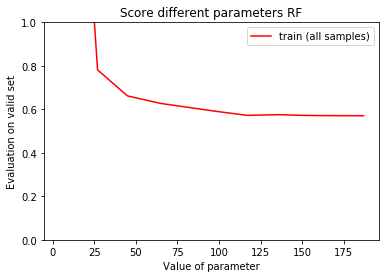

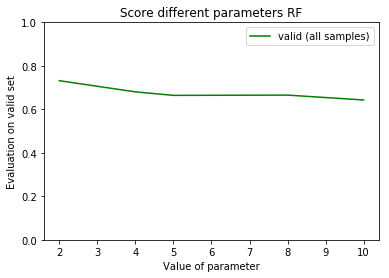

In [273]:
import matplotlib.pyplot as plt

plt.plot(score_tree[0], score_tree[1], "r", label='train (all samples)')
plt.title("Score different parameters RF")
plt.xlabel("Value of parameter")
plt.ylabel("Evaluation on valid set")
plt.legend()
plt.ylim((0, 1))
plt.show()

plt.plot(score_maxFeat[0], score_maxFeat[1], "g", label='valid (all samples)')
plt.title("Score different parameters RF")
plt.xlabel("Value of parameter")
plt.ylabel("Evaluation on valid set")
plt.legend()
plt.ylim((0, 1))
plt.show()